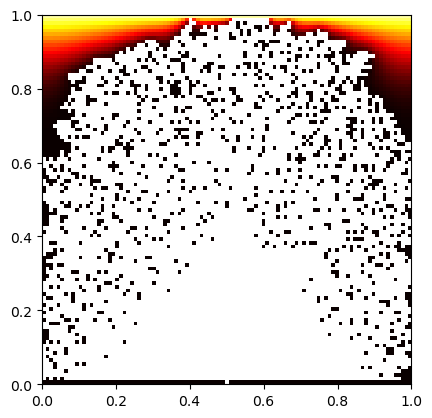

In [37]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
from numba import jit


@jit(nopython=True, parallel = False)
def sor(C, cluster,w,stop = 0.0001):
    """
    Performs Successive over relaxation.
    Inputs:
        - C: Matrix A with all values
        - cluster: Matrix with all the sink and cluster positions
        - w: weight
        - stop: simulation stopper
    """

    
    A = C.copy()
    n_count = 0
    non_cte = np.where(cluster == 0)

    while True:
        n_count += 1 
        A_b = A.copy()
        for i in np.unique(non_cte[0]):
            for j in non_cte[1][non_cte[0] == i]:
                if j == 1:
                    A[i,1] = (w/4)*(A[i+1,1] + A[i-1,1] + A[i,2] + A[i,-3]) + (1-w)*A[i,1]

                elif j == (A.shape[0]-2):
                    A[i,-2] = (w/4)*(A[i+1,-2] + A[i-1,-2] + A[i,2] + A[i,-3]) + (1-w)*A[i,-2]
                else:
                    A[i,j] = (w/4)*(A[i+1,j] + A[i-1,j] + A[i,j+1] + A[i,j-1])+ (1-w)*A[i,j]
        
        max_diff = np.max(np.abs(A - A_b))
        
        if  max_diff <= stop:
            return A.copy(), n_count
            break
        

@jit(nopython=True, parallel = False)  
def growth_model(N, position,w,eta, grow_steps = 200, D = 1):
    """

    Executes a time_step ing method given a function

    Inputs:

        - N: Number of divisions
        - w: The SOR parameter
        - eta: eta I Imagine
        - grow_steps: Number of total steps it will do, default + 1000
    """
    C = np.zeros((N+3, N+3)) ## Matrix with concentration
    number = 20
    C[1,:] = 1
    
    C[0,:] = number
    C[-1,:] = number
    C[:,0] = number
    C[:,-1] = number

    data = [C.copy()]
    
    
    cluster = np.zeros((N+3, N+3)) ## Matrix with points. 1 is limit, 2 is sink point, 0 is nothing

    cluster[1,:] = 1
    cluster[-2,:] = 1

    cluster[0,:] = number
    cluster[-1,:] = number
    cluster[:,0] = number
    cluster[:,-1] = number

    cluster[-2,position] = 2

    n_count = 0
    n_sum = 0

    
    for i in range(1,grow_steps):
        [C, n_count] = sor(C,cluster,w)
        n_sum += n_count
        
        # Finding all the candidates
        sink = np.where(cluster == 2)
        candidate_0 = [] # ROW
        candidate_1 = [] # Column
        c_candidate = 0
        tag = np.zeros((N + 3, N + 3)) 

        for k in range(len(sink[0])):
            a = sink[0][k]
            b = sink[1][k]

            if a == 0 or a == N + 2 or b == 0 or b == N + 2:
                continue
            else:
                for i in [a - 1, a + 1]:
                    if cluster[i][b] == 0 and tag[i][b] == 0:
                        candidate_0.append(i)
                        candidate_1.append(b)
                        tag[i][b] = 1
                        c_candidate += C[candidate_0[-1]][candidate_1[-1]]
                for j in [b - 1, b + 1]:
                    if cluster[a][j] == 0 and tag[a][j] == 0:
                        candidate_0.append(a)
                        candidate_1.append(j)
                        tag[a][j] = 1
                        c_candidate += C[candidate_0[-1]][candidate_1[-1]]

        # calculating the probability of becoming a sink for candidates
        for k in range(len(candidate_0)):
            if (C[candidate_0[k]][candidate_1[k]] ** eta) / c_candidate > np.random.uniform(0,1):
                C[candidate_0[k]][candidate_1[k]] = 0
                cluster[candidate_0[k]][candidate_1[k]] = 2
        data.append(C.copy())
        

    return C, cluster, data, n_sum


def merge(C, cluster):
    # C and cluster are 3-dimensional matrices
    A = np.copy(C)
    sink = np.where(cluster == 2)

    for i in range(len(sink[0])):
        A[sink[0][i]][sink[1][i]] = 1.1

    return A

if __name__ == "__main__":
    N = 100
    w = 1.9
    eta = 0.1

    result = growth_model(N, round(N/2+1) ,w,eta)
    data = result[0]
    cluster = result[1]
    iteration = result[3]
    figure = merge(data, cluster)
    
    fig, ax = plt.subplots()
    plt.imshow(figure[1:-1, 1:-1], cmap='hot', interpolation='nearest', extent=[0, 1, 0, 1], label = f'η = {eta}')
    plt.savefig('Q1_eta01')



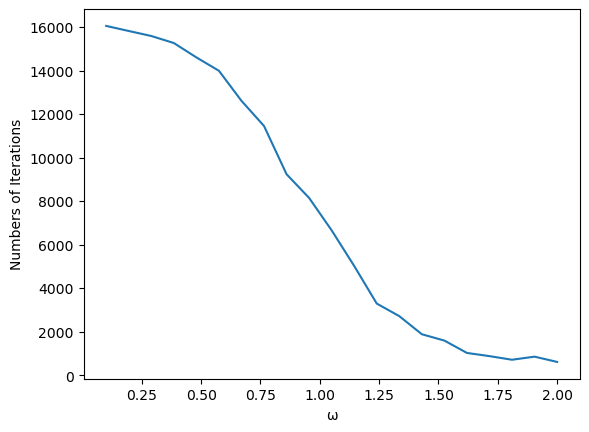

In [16]:
N = 100
w = 1.9
iteration_array = []

for eta in np.linspace(0.1, 2, 21):
    result = growth_model(N, round(N/2+1) ,w,eta)
    iteration_array.append(result[3])

plt.plot(np.linspace(0.1, 2, 21), iteration_array)
plt.xlabel(r'$\eta$')
plt.ylabel('Numbers of Iterations')

plt.savefig('Q1_eta')

In [33]:
iteration_array

[16052,
 15819,
 15589,
 15266,
 14605,
 13990,
 12609,
 11452,
 9235,
 8146,
 6655,
 5017,
 3290,
 2712,
 1880,
 1588,
 1020,
 873,
 707,
 849,
 607]

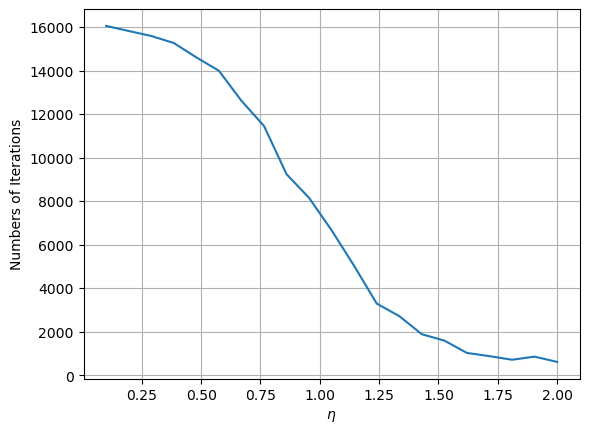

In [32]:
plt.plot(np.linspace(0.1, 2, 21), iteration_array)
plt.xlabel(r'$\eta$')
plt.ylabel('Numbers of Iterations')
plt.grid()

plt.savefig('Q1_eta')

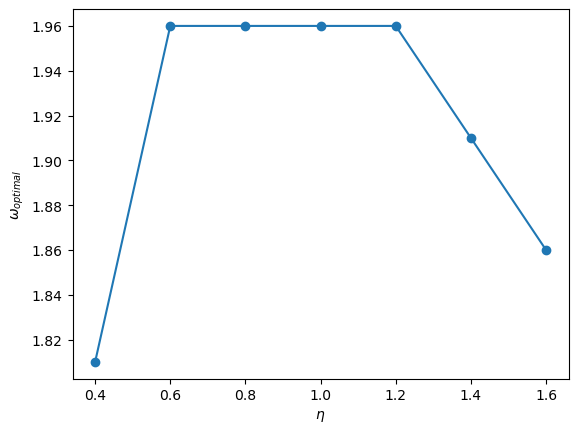

In [27]:
def w_optimizer(etas,ws, delta = 0.001):
    '''
    Creates a Simulation Grid of given size and calculates best w within range
    '''
    results = []
    for eta in etas:
        max_iterations = float('inf')
        best_w = None
        for wx in ws:
#           print(wx)
            result = growth_model(N, round(N/2+1) ,w,eta)
            iterations  = result[3]
            if iterations < max_iterations:
                max_iterations = iterations
#                 print(max_iterations)
                best_w = wx
#         print((N,best_w))
        results.append((eta,best_w))
    return results    


N = 100
etas = [0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6]
ws = np.arange(1.71,1.99,0.01)
w_results = w_optimizer(etas, ws, delta = 0.001)

w_results = np.array(w_results)
plt.plot(w_results[:,0], w_results[:,1])
plt.scatter(w_results[:,0], w_results[:,1])
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega_{{optimal}}$')

plt.savefig('Q1_optimal_w')

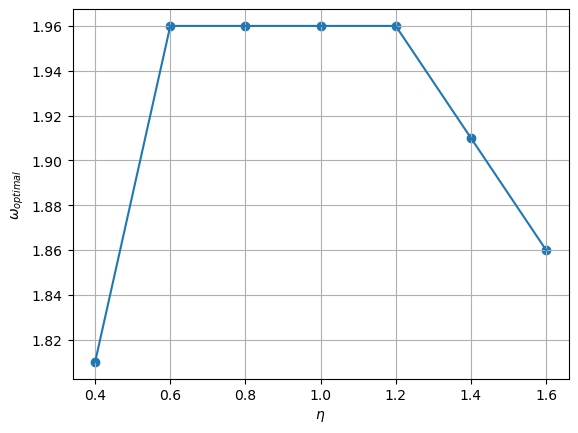

In [30]:
plt.plot(w_results[:,0], w_results[:,1])
plt.scatter(w_results[:,0], w_results[:,1])
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\omega_{{optimal}}$')
plt.grid()

plt.savefig('Q1_optimal_w')